In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.metrics import accuracy_score, f1_score

# SVM

In this notebook we train an SVM on the MICE imputed dataset.  

We first randomly shuffle and split the dataset into train and test sets and reduce them to the sizes of 400 and 200.  
We the use Grid Search to adjust the C, gamma and kernel.  

We then train and evaluate the SVM with those parameters on every single of our target variales separately. We also train it on has_dep_diag using class_weight for balancing.  
We then plot the learning curve for the model.  

We also try out NuSVC with no success.  

We normalize the data and train an SVM on them oth without and with auto balancing.  
Using random undersampling we obtain a balanced data subset. We run and SVM on it. We also run an SVM on this subset, but normalised.

We apply PCA to the data and try to plot the decision boundaries.

Then we plot the ROC curves for the combinations of:
+ Imbalanced train set, imbalanced evaluation
+ Balanced train set, imbalanced evaluation
+ Imbalanced train set, balanced evaluation
+ Balanced train set, balanced evaluation

In [2]:
data0 = pd.read_csv("newdata3.csv", engine='python')
data1 = pd.read_csv("imputed_dataset_1.csv", engine='python')
data1.head()
data2 = pd.read_csv("imputed_dataset_2.csv", engine='python')
data2.head()
data3 = pd.read_csv("imputed_dataset_3.csv", engine='python')
data3.head()
data4 = pd.read_csv("imputed_dataset_4.csv", engine='python')
data4.head()
data5 = pd.read_csv("imputed_dataset_5.csv", engine='python').drop(['Unnamed: 0'], axis = 1)

In [3]:
data5.head()

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
2,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
3,49.812426,160.224186,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0


## Prepare the data:

Separate target from data.

In [4]:
X = data5.drop(['has_dep_diag'],axis=1).drop(['secd_diag'],axis=1).drop(['prim_diag'],axis=1).drop(['dep_score'],axis=1).drop(['dep_thoughts'],axis=1).drop(['panic_score'], axis=1)
print(X.shape)
Y = np.column_stack((data5['has_dep_diag'], data5['secd_diag'], data5['prim_diag'], data5['dep_score'], data5['dep_thoughts']))
print(Y.shape)

(13734, 36)
(13734, 5)


Randomly shuffle the dataset.

In [5]:
from random import shuffle

def shuffle_dataset(N, X, y, X_shuffled, y_shuffled):
    ind_list = [i for i in range(N)]
    shuffle(ind_list)
    X_shuffled  = X.iloc[ind_list]
    y_shuffled = y.iloc[ind_list]

In [6]:
X_shuffled = X
y_shuffled = Y
shuffle_dataset(13734, pd. DataFrame(X), pd. DataFrame(Y), pd. DataFrame(X_shuffled), pd. DataFrame(y_shuffled))

Train-test split.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled,test_size=0.3, random_state=40)
print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)

(9613, 36)
(4121, 36)
(9613, 5)
(4121, 5)


Reduce the dataset.

In [8]:
X_train_reduced, y_train_reduced = X_train[0:400], y_train[0:400]
X_test_reduced, y_test_reduced = X_test[0:200], y_test[0:200]
print(X_train_reduced.shape); print(X_test_reduced.shape)
print(y_train_reduced.shape); print(y_test_reduced.shape)

(400, 36)
(200, 36)
(400, 5)
(200, 5)


In [9]:
from collections import Counter
Counter(y_train_reduced[:,0])

Counter({0.0: 381, 1.0: 19})

## Train model:
####  Imputed dataset 5, for has_dep_diag 

In [10]:
from sklearn import svm
from sklearn.svm import SVC

### Tune hyperparameters

In [12]:
## on f1 macro
import time
from sklearn.model_selection import GridSearchCV

start = time.perf_counter()

param_grid = {
    'C': [0.1,1, 5, 10, 100], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'sigmoid', 'linear', 'poly']
}
tuned_svm = GridSearchCV(SVC(), param_grid, cv = 5, scoring='f1_macro' , verbose = 2, n_jobs=-1)
tuned_svm.fit(X_train_reduced, y_train_reduced[:,0])

end = time.perf_counter()

params = tuned_svm.best_params_

print(params)
print(tuned_svm.score(X_train,y_train[:,0]))
print(tuned_svm.score(X_test,y_test[:,0]))
y_pred = tuned_svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = tuned_svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))


print(str((end - start)) + ' mins')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
0.5481230351851158
0.5125063309072234
0.5481230351851158
0.5125063309072234
39.29264523599704 mins


Basic SVM, with accuracy and f1-score:

In [13]:
bar_x = np.array([0, 1, 2, 3, 4])
bar_y = np.array([])

In [14]:
##imbalanced
#svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

bar_y = np.append(bar_y, f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.9835639238531155
SVM classifier accuracy - test set: 0.9716088328075709
0.7973116592095809
0.4928


In [15]:
##auto balancing
#svm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.9766982211588474
SVM classifier accuracy - test set: 0.9378791555447706
0.8488531348919115
0.5514588336133768


#### All the other targets:

In [16]:
#svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train[:,1])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,1])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,1])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,1], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,1], average = "macro"))

bar_y = np.append(bar_y, f1_score(y_pred_test, y_test[:,1], average = "macro"))

SVM classifier accuracy: 0.9288463538957662
SVM classifier accuracy - test set: 0.8371754428536763
0.7299424596417491
0.21216648388671538


In [17]:
#svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train[:,2])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,2])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,2])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,2], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,2], average = "macro"))

bar_y = np.append(bar_y, f1_score(y_pred_test, y_test[:,2], average = "macro"))

SVM classifier accuracy: 0.9025278269010715
SVM classifier accuracy - test set: 0.7279786459597185
0.7748325247953213
0.1491549080150774


In [18]:
#svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train[:,3])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,3])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,3])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,3], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,3], average = "macro"))

bar_y = np.append(bar_y, f1_score(y_pred_test, y_test[:,3], average = "macro"))

SVM classifier accuracy: 0.9288463538957662
SVM classifier accuracy - test set: 0.8410579956321281
0.805389018960321
0.34309855644252973


In [19]:
#svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train_reduced, y_train_reduced[:,4])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,4])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,4])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,4], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,4], average = "macro"))

bar_y = np.append(bar_y, f1_score(y_pred_test, y_test[:,4], average = "macro"))

SVM classifier accuracy: 0.7086237386871944
SVM classifier accuracy - test set: 0.6993448192186362
0.3882198387456414
0.346648460891229


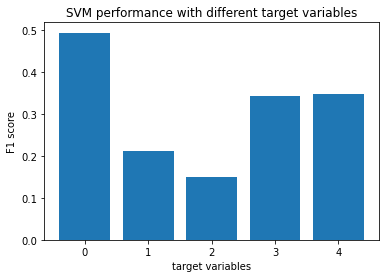

In [20]:
plt.bar(bar_x, bar_y)
plt.title('SVM performance with different target variables')
plt.xlabel('target variables')
plt.ylabel('F1 score')
plt.show()

## Exploration:

In [32]:
from sklearn.model_selection import learning_curve

#plot learning curve function from the labs
def plot_learning_curve(n, est, xs, ys, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator = est, X = xs, y = ys, cv = n)

    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', label='Training Accuracy')
    plt.plot(train_sizes, valid_mean, color='green', label='Validation Accuracy')

    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()


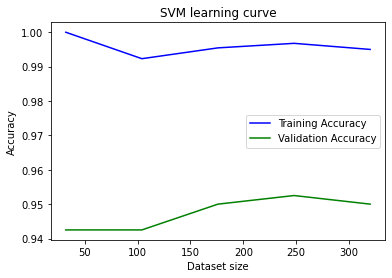

In [33]:
plot_learning_curve(5, SVC(C=5, gamma='auto', kernel='rbf'),X_train_reduced, y_train_reduced[:,0], 'SVM learning curve')

## Tune hypermarameters:

In [25]:
##on accuracy
import time
from sklearn.model_selection import GridSearchCV

start = time.perf_counter()

param_grid = {
    'C': [0.1,1, 5, 10, 100], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'sigmoid']
}
tuned_svm = GridSearchCV(SVC(), param_grid, cv = 5, scoring='accuracy', verbose = 2, n_jobs=-1)
tuned_svm.fit(X_train_reduced, y_train_reduced[:,0])

end = time.perf_counter()

params = tuned_svm.best_params_

print(params)
print(tuned_svm.score(X_train,y_train[:,0]))
print(tuned_svm.score(X_test,y_test[:,0]))
y_pred = tuned_svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = tuned_svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))
print(str((end - start)) + ' mins')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.9710808280453552
0.9728221305508372
0.492664133417775
0.49311193111931123
0.17924579999998969 mins


## NuSVC

In [34]:
from sklearn.svm import NuSVC
## the largst nu I was allowed
svm = NuSVC(nu = 0.05)
svm.fit(X_train, y_train[:,0])

print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.6799126183293457
SVM classifier accuracy - test set: 0.6915797136617325
0.4509202948812156
0.4484762205109116


## On normalized data:

In [35]:
from sklearn import preprocessing

normalized_data = preprocessing.normalize(X_shuffled)
normalized_target = preprocessing.normalize(y_shuffled)
print(normalized_data[0,:])
print(normalized_target[0,:])

[0.31011812 0.94981285 0.         0.         0.00523017 0.00523017
 0.00523017 0.01046033 0.         0.00523017 0.01046033 0.00523017
 0.         0.00523017 0.01046033 0.01046033 0.00523017 0.
 0.         0.00523017 0.01046033 0.         0.00523017 0.01046033
 0.00523017 0.         0.00523017 0.01046033 0.01046033 0.00523017
 0.         0.00261508 0.00261508 0.02092066 0.         0.00523017]
[0. 0. 0. 0. 1.]


In [37]:
from sklearn.model_selection import train_test_split

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(normalized_data, y_shuffled,test_size=0.3, random_state=40)
print(X_train_norm.shape); print(X_test_norm.shape)
print(y_train_norm.shape); print(y_test_norm.shape)
X_train_reduced_norm, y_train_reduced_norm = X_train_norm[0:400], y_train_norm[0:400]
X_test_reduced_norm, y_test_reduced_norm = X_test_norm[0:200], y_test_norm[0:200]
print(X_train_reduced_norm.shape); print(X_test_reduced_norm.shape)
print(y_train_reduced_norm.shape); print(y_test_reduced_norm.shape)

(9613, 36)
(4121, 36)
(9613, 5)
(4121, 5)
(400, 36)
(200, 36)
(400, 5)
(200, 5)


In [38]:
##imbalanced
svm_norm = SVC(C=5, gamma='auto', kernel='rbf')
svm_norm.fit(X_train_norm, y_train_norm[:,0])
print(f'SVM classifier accuracy: {svm_norm.score(X_train_norm, y_train_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_norm.score(X_test_norm, y_test_norm[:,0])}')

y_pred_norm = svm_norm.predict(X_train_norm)
print(f1_score(y_pred_norm, y_train_norm[:,0], average = "macro"))
y_pred_test_norm = svm_norm.predict(X_test_norm)
print(f1_score(y_pred_test_norm, y_test_norm[:,0], average = "macro"))

SVM classifier accuracy: 0.9710808280453552
SVM classifier accuracy - test set: 0.9728221305508372
0.492664133417775
0.49311193111931123


In [40]:
##auto balancing
##has_dep_diag
svm_norm = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm_norm.fit(X_train_norm, y_train_norm[:,0])
print(f'SVM classifier accuracy: {svm_norm.score(X_train_norm, y_train_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_norm.score(X_test_norm, y_test_norm[:,0])}')

y_pred_norm = svm_norm.predict(X_train_norm)
print(f1_score(y_pred_norm, y_train_norm[:,0], average = "macro"))
y_pred_test_norm = svm_norm.predict(X_test_norm)
print(f1_score(y_pred_test_norm, y_test_norm[:,0], average = "macro"))

SVM classifier accuracy: 0.959117861229585
SVM classifier accuracy - test set: 0.9602038340208687
0.525010532874828
0.5185720228631346


#### other targets:

In [41]:
##auto balancing
##secd_diag
svm = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm.fit(X_train, y_train[:,1])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,1])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,1])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,1], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,1], average = "macro"))

SVM classifier accuracy: 0.8667429522521586
SVM classifier accuracy - test set: 0.8240718272264014
0.788654709695681
0.21549902470429322


In [42]:
##auto balancing
##prim_diag
svm = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm.fit(X_train, y_train[:,2])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,2])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,2])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,2], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,2], average = "macro"))

SVM classifier accuracy: 0.8211796525538334
SVM classifier accuracy - test set: 0.6753215239019655
0.7816698968147355
0.19502957010049057


In [43]:
##auto balancing
##dep_score
svm = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm.fit(X_train, y_train[:,3])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,3])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,3])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,3], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,3], average = "macro"))

SVM classifier accuracy: 0.8955580984084053
SVM classifier accuracy - test set: 0.8352341664644504
0.8573057565059617
0.376113890185654


In [44]:
##auto balancing
##dep_thoughts
svm = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm.fit(X_train, y_train[:,4])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,4])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,4])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,4], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,4], average = "macro"))

SVM classifier accuracy: 0.8944138146260272
SVM classifier accuracy - test set: 0.7359864110652754
0.8497689347848918
0.3990067262044544


## Random over and undersampling:

In [45]:
from itertools import chain, combinations
from scipy import stats
#dep = np.random.choice(df,replace = False, size = n)
dep = data5.query('has_dep_diag in [1.0]')
dep = dep.sample(n = 200, random_state = 1)
no_dep = data5.query('has_dep_diag in [0.0]')
no_dep = no_dep.sample(n = 200, random_state = 1)

balanced = dep.append(no_dep)

Xb = balanced.drop(['has_dep_diag'],axis=1).drop(['secd_diag'],axis=1).drop(['prim_diag'],axis=1).drop(['dep_score'],axis=1).drop(['dep_thoughts'],axis=1).drop(['panic_score'], axis=1)
print(Xb.shape)
Yb = np.column_stack((balanced['has_dep_diag'], balanced['secd_diag'], balanced['prim_diag'], balanced['dep_score'], balanced['dep_thoughts']))
print(Yb.shape)

Xb_shuffled = Xb
yb_shuffled = Yb
shuffle_dataset(200, pd. DataFrame(Xb), pd. DataFrame(Yb), pd. DataFrame(Xb_shuffled), pd. DataFrame(yb_shuffled))

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb_shuffled, yb_shuffled,test_size=0.5, random_state=40)
print(Xb_train.shape); print(Xb_test.shape)
print(yb_train.shape); print(yb_test.shape)
#def random_sampling(df, n):
 #   random_sample = np.random.choice(df,replace = False, size = n)
  #  return(random_sample)
#randomSample = random_sampling(population_df, N)

(400, 36)
(400, 5)
(200, 36)
(200, 36)
(200, 5)
(200, 5)


In [47]:
svm_b = SVC(C=5, gamma='auto', kernel='rbf')
svm_b.fit(Xb_train, yb_train[:,0])
print(f'SVM classifier accuracy: {svm_b.score(Xb_train, yb_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_b.score(Xb_test, yb_test[:,0])}')

y_pred = svm_b.predict(Xb_train)
print(f1_score(y_pred, yb_train[:,0], average = "macro"))
y_pred_test = svm_b.predict(Xb_test)
print(f1_score(y_pred_test, yb_test[:,0], average = "macro"))

SVM classifier accuracy: 0.985
SVM classifier accuracy - test set: 0.68
0.9849906191369606
0.6791979949874686


In [48]:
print(f'SVM classifier accuracy: {svm_b.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_b.score(X_test, y_test[:,0])}')

y_pred = svm_b.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm_b.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.6494330593987309
SVM classifier accuracy - test set: 0.6561514195583596
0.4493106857879846
0.4470988691457688


#### random sample + normalisation

In [49]:
normalized_data = preprocessing.normalize(Xb_shuffled)
normalized_target = preprocessing.normalize(yb_shuffled)
print(normalized_data[0,:])
print(normalized_target[0,:])

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(normalized_data, yb_shuffled,test_size=0.5, random_state=40)
print(X_train_norm.shape); print(X_test_norm.shape)
print(y_train_norm.shape); print(y_test_norm.shape)
X_train_reduced_norm, y_train_reduced_norm = X_train_norm[0:400], y_train_norm[0:400]
X_test_reduced_norm, y_test_reduced_norm = X_test_norm[0:200], y_test_norm[0:200]
print(X_train_reduced_norm.shape); print(X_test_reduced_norm.shape)
print(y_train_reduced_norm.shape); print(y_test_reduced_norm.shape)

[0.33008443 0.93922408 0.         0.00569745 0.00569745 0.01139489
 0.00569745 0.01139489 0.         0.00569745 0.00569745 0.00569745
 0.00569745 0.00569745 0.01139489 0.00569745 0.00569745 0.00569745
 0.00569745 0.00569745 0.01139489 0.         0.00569745 0.00569745
 0.00569745 0.00569745 0.00569745 0.01139489 0.00569745 0.00569745
 0.         0.00284872 0.08546168 0.01709234 0.         0.        ]
[0.09128709 0.09128709 0.91287093 0.27386128 0.27386128]
(200, 36)
(200, 36)
(200, 5)
(200, 5)
(200, 36)
(200, 36)
(200, 5)
(200, 5)


In [50]:
svm_norm = SVC(C=5, gamma='auto', kernel='rbf')
svm_norm.fit(X_train_norm, y_train_norm[:,0])
print(f'SVM classifier accuracy: {svm_norm.score(X_train_norm, y_train_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_norm.score(X_test_norm, y_test_norm[:,0])}')

y_pred_norm = svm_norm.predict(X_train_norm)
print(f1_score(y_pred_norm, y_train_norm[:,0], average = "macro"))
y_pred_test_norm = svm_norm.predict(X_test_norm)
print(f1_score(y_pred_test_norm, y_test_norm[:,0], average = "macro"))

SVM classifier accuracy: 0.505
SVM classifier accuracy - test set: 0.495
0.3355481727574751
0.33110367892976583


## Decision Boundaries

SVC on the deataset with reduced dimensionality (PCA)

In [32]:
#non-normalized
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.fit_transform(X_test_reduced)

svm_pca = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm_pca.fit(X_pca, y_train_reduced[:,0])
print(f'SVM classifier accuracy: {svm_pca.score(X_pca, y_train_reduced[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_pca.score(X_test_pca, y_test_reduced[:,0])}')
y_pred = svm_pca.predict(X_pca)
print(f1_score(y_pred, y_train_reduced[:,0], average = "macro"))
y_pred_test = svm_pca.predict(X_test_pca)
print(f1_score(y_pred_test, y_test_reduced[:,0], average = "macro"))

SVM classifier accuracy: 0.9525
SVM classifier accuracy - test set: 0.98
0.48783610755441736
0.494949494949495


In [51]:
#normalized
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_reduced_norm)
X_test_pca = pca.fit_transform(X_test_reduced_norm)

svm_pca = SVC(C=5, gamma='auto', kernel='rbf', class_weight = 'balanced')
svm_pca.fit(X_pca, y_train_reduced_norm[:,0])
print(f'SVM classifier accuracy: {svm_pca.score(X_pca, y_train_reduced_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_pca.score(X_test_pca, y_test_reduced_norm[:,0])}')
y_pred = svm_pca.predict(X_pca)
print(f1_score(y_pred, y_train_reduced_norm[:,0], average = "macro"))
y_pred_test = svm_pca.predict(X_test_pca)
print(f1_score(y_pred_test, y_test_reduced_norm[:,0], average = "macro"))

SVM classifier accuracy: 0.53
SVM classifier accuracy - test set: 0.525
0.3967398280066743
0.39395872539950877


In [52]:
from matplotlib.colors import ListedColormap
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = {0.0:'red', 1.0:'green'}  
    print(Z.shape)
    print(Z.ravel().shape)
    print(X[:, 0].shape)
    print(X[:, 1].shape)
    
    colored_labels = np.array([colors[xi] for xi in y]) #Z.ravel()
    plt.contourf(xx, yy, Z, cmap='viridis')


    cb = plt.colorbar()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=colored_labels, cmap='viridis', s=10)

    plt.show()

(24, 25)
(600,)
(200,)
(200,)


ValueError: 'c' argument has 400 elements, which is inconsistent with 'x' and 'y' with size 200.

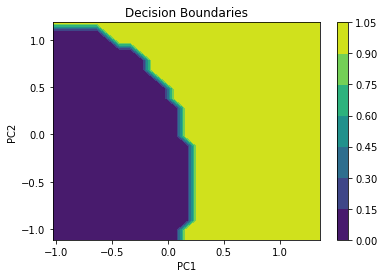

In [53]:
##can break the whole notebook on the non-normalized PCA
plot_decision_boundaries(X_pca, y_train_reduced[:,0], svm_pca, 'Decision Boundaries')


## ROC Curves

Imbalanced train set, imbalanced evaluation

In [54]:
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.9835639238531155
SVM classifier accuracy - test set: 0.9716088328075709
0.7973116592095809
0.4928


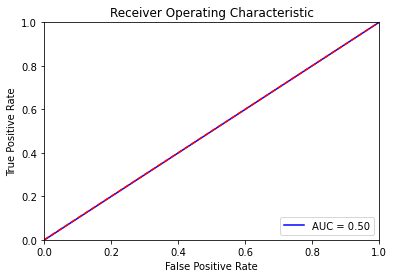

In [55]:
import sklearn.metrics as metrics
preds = svm.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test[:,0], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Balanced train set, imbalanced evaluation

In [56]:
svm_b = SVC(C=5, gamma='auto', kernel='rbf')
svm_b.fit(Xb_train, yb_train[:,0])
print(f'SVM classifier accuracy: {svm_b.score(Xb_train, yb_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_b.score(Xb_test, yb_test[:,0])}')

y_pred = svm_b.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm_b.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.985
SVM classifier accuracy - test set: 0.68
0.4493106857879846
0.4470988691457688


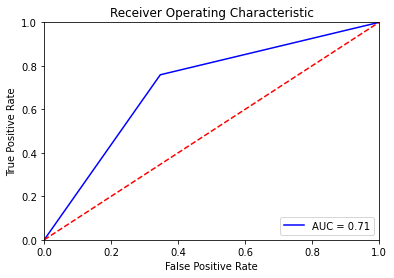

In [57]:
import sklearn.metrics as metrics
preds = svm_b.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test[:,0], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Imbalanced train set, balanced evaluation

In [59]:
svm = SVC(C=5, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(Xb_train, yb_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(Xb_test, yb_test[:,0])}')

y_pred = svm.predict(Xb_train)
print(f1_score(y_pred, yb_train[:,0], average = "macro"))
y_pred_test = svm.predict(Xb_test)
print(f1_score(y_pred_test, yb_test[:,0], average = "macro"))

SVM classifier accuracy: 0.67
SVM classifier accuracy - test set: 0.635
0.6268656716417911
0.5823679167024228


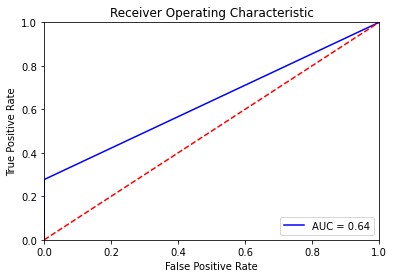

In [60]:
import sklearn.metrics as metrics
preds = svm.predict(Xb_test)
fpr, tpr, threshold = metrics.roc_curve(yb_test[:,0], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Balanced train set, balanced evaluation

In [61]:
svm_b = SVC(C=5, gamma='auto', kernel='rbf')
svm_b.fit(Xb_train, yb_train[:,0])
print(f'SVM classifier accuracy: {svm.score(Xb_train, yb_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(Xb_test, yb_test[:,0])}')

y_pred = svm_b.predict(Xb_train)
print(f1_score(y_pred, yb_train[:,0], average = "macro"))
y_pred_test = svm_b.predict(Xb_test)
print(f1_score(y_pred_test, yb_test[:,0], average = "macro"))

SVM classifier accuracy: 0.67
SVM classifier accuracy - test set: 0.635
0.9849906191369606
0.6791979949874686


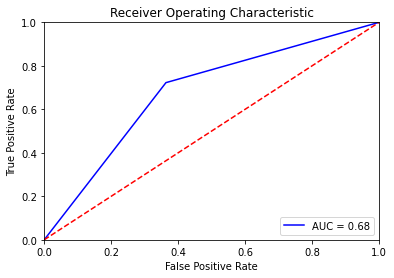

In [62]:
import sklearn.metrics as metrics
preds = svm_b.predict(Xb_test)
fpr, tpr, threshold = metrics.roc_curve(yb_test[:,0], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()